In [3]:
import torch 
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable

# from dataset.readVideo import DramaDataset
from dataset.translate import TranslateDataset as DramaDataset

from utils.tokenMaker import Lang
from utils.tool import padding
import pickle
import os
import matplotlib.pyplot as plt
from Similarity.model import GesdSimilarity

useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
def calBLEU(hypothesis, reference):
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, smoothing_function=smoothie)
    return BLEUscore

In [15]:
DataDir="translate/eng_fra_dataset"

datasets = DramaDataset(basedir=DataDir,
                        maxFrame=0,
                        timeOffset=0.2,
                        startSeries=120000,
                        maxSeries=130000,
                        useBmp=True,
                        randomStart=False, subOffset=0, subMax=200)
loader = torch.utils.data.DataLoader(datasets, batch_size=64, shuffle=True, num_workers=4)
it = iter(loader)
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

def makeNegSample(pres, nexs, negSize):
    mpres = []
    mnexts = []
    scores = []
    for pre, nex in zip(pres, nexs):
        while True:
            negs = random.sample(nexs, negSize)
            if not nex in negs:
                break
        mpres +=[pre] * (negSize + 1)
        mnexts += [nex] + negs
        scores += [1] + [0] * negSize
    return mpres, mnexts, scores
vectorTransforms = [lambda x: torch.LongTensor(x).to(device)]
def sentenceToVector(sentences, lang, sos=False, eos=False):
    vectors = []
    for s in sentences:
        vectors.append(lang.sentenceToVector(s, sos=sos, eos=eos))
    vectors = padding(vectors, lang["PAD"], vectorTransforms)
    return vectors

In [6]:
ModelDir = "Similarity/models/Translate"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SimilarityModel.7.pth")).to(device).eval()

Load lang model: Similarity/models/Translate. Word size: 32107


In [16]:
pres, nexs, imgs = it.next()

In [22]:

p,n,s = makeNegSample(pres, nexs, negSize=5)
vpres = sentenceToVector(p, lang)
vnexts = sentenceToVector(n, lang)
scores = torch.Tensor(s).to(device)
outputs = model(vpres, vnexts)
(outputs.round() == scores).float().mean()

tensor(0.9661, device='cuda:0')

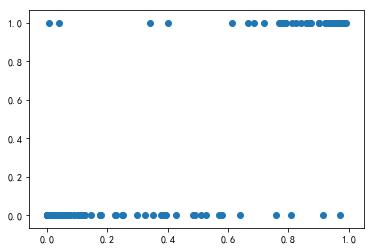

In [23]:
plt.scatter(outputs.cpu().detach().numpy(), scores.cpu().detach().numpy())
plt.show()

In [31]:
import pandas as pd
import numpy as np

allresult = pd.read_json("others/result_bk_ch_sub_ins.json")[["epoch", "pre", "next", "make"]]
allresult[:5]

,epoch,pre,next,make
0,1,你才不是黑木耳,你的陰道好看得不得了,我就知道 你的頭發現在哪里
1,1,噢 墨西哥餐廳,我把拉丁美洲的市場給忘了,我的天生就是一個大的
10,1,在這呢,好了 各就各位 攝像機準備,這不是什麼事情啊
100,2,愿意共進晚餐嗎 我該怎么辦,裝沒看見啊 就跟我對那桌,但是啊 我還以為是 沒 但是我的頭發
101,2,慢著 我們只是要跟他合影,除此之外沒別的 對吧 對,這是我們的目標


In [33]:
epoch = 1
fullResult = pd.DataFrame()
while True:
    result = allresult.loc[allresult['epoch'] == epoch].copy(True)
    if len(result) == 0:
        break
    part = result
    part["score"] = (result["next"] == result["make"])
    part["bleu"] = [calBLEU(row["next"], row["make"]) for i, row in result.iterrows()]
    fullResult = fullResult.append(part, ignore_index=True)
    epoch += 1

In [5]:
epoch = 1
fullResult = pd.DataFrame()
while True:
    result = allresult.loc[allresult['epoch'] == epoch].copy(True)
    if len(result) == 0:
        break
    vpres = sentenceToVector(result["pre"], lang)
    vnexts = sentenceToVector(result["make"], lang)
    outputs = model(vpres, vnexts)
    part = result
    part["score"] = outputs.detach()
    fullResult = fullResult.append(part, ignore_index=True)
    epoch += 1

NameError: name 'lang' is not defined

In [6]:
rdfullResult = fullResult

In [12]:
ffullResult = fullResult

In [18]:
np.arange(20, 221, 20)

array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220])

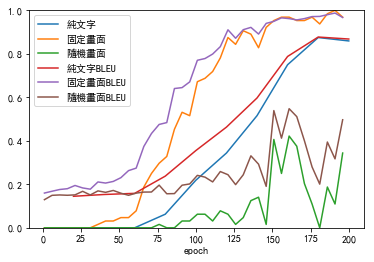

In [46]:
import numpy as np
typ = "score"
typ2 = "bleu"
plt.plot(np.arange(20, 201, 20), fullResult.groupby("epoch").mean()[typ], label="純文字")
plt.plot(np.arange(1, 201, 5), ffullResult.groupby("epoch").mean()[typ], label="固定畫面")
plt.plot(np.arange(1, 201, 5), rdfullResult.groupby("epoch").mean()[typ], label="隨機畫面")
plt.plot(np.arange(20, 201, 20), fullResult.groupby("epoch").mean()[typ2], label="純文字BLEU")
plt.plot(np.arange(1, 201, 5), ffullResult.groupby("epoch").mean()[typ2], label="固定畫面BLEU")
plt.plot(np.arange(1, 201, 5), rdfullResult.groupby("epoch").mean()[typ2], label="隨機畫面BLEU")
plt.legend()
plt.xlabel("epoch")
plt.ylim((0,1))
plt.show()

count    64.000000
mean      0.882138
std       0.120983
min       0.076649
25%       0.859756
50%       0.915470
75%       0.938206
max       0.981638
Name: score, dtype: float64


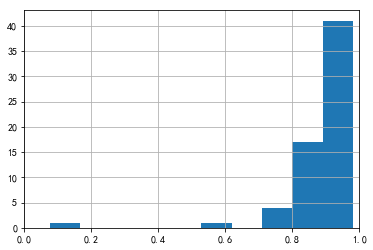

In [12]:
partDatas = fullResult.loc[fullResult['epoch'] == 30]
partDatas["score"].hist().set_xlim(0,1)
print(partDatas["score"].describe())
plt.show()

In [13]:
from utils.tool import getLastOutputs
s1Sentence, s1Lengths = vpres
s2Sentence, s2Lengths = vnexts

feature1, _ = model.preEncoder(s1Sentence)
feature2, _ = model.nextEncoder(s2Sentence)

feature1 = getLastOutputs(feature1, s1Lengths)
feature2 = getLastOutputs(feature2, s2Lengths)

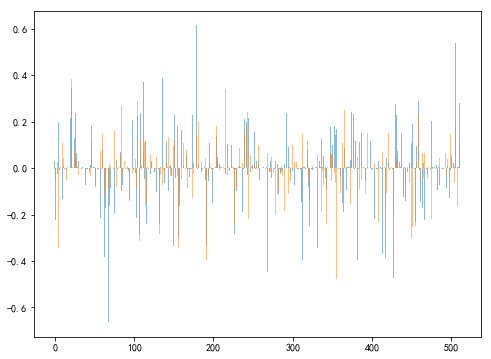

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
x = range(0, feature1[0].size(0))
plt.bar(x, feature1[0].detach(), alpha=0.5)
plt.bar(x, feature2[0].detach(), alpha=0.5)
plt.show()

In [15]:
parts = allresult.loc[allresult['epoch'] == 30].copy(True)

In [16]:
def orderScore(parts, dataSize = 20):
    allMake = []
    allNext = []
    for index, row in parts.iterrows():
        while True:
            negSamples = parts.sample(dataSize-2)
            if row["make"] not in negSamples["next"].tolist():
                break
        pres = [row["pre"]] * dataSize
        nexs = [row["make"]]+[row["next"]]+negSamples["next"].tolist()
        vpres = sentenceToVector(pres, lang)
        vnexts = sentenceToVector(nexs, lang)
        outputs = model(vpres, vnexts)
        order = outputs.topk(dataSize)[1].detach().cpu().numpy().tolist()
        iMake = order.index(0)
        iNext = order.index(1)
        allMake.append(iMake)
        allNext.append(iNext)
    return torch.Tensor(allMake).mean().item(), torch.Tensor(allNext).mean().item()

In [21]:
epoch = 0
makeScores = []
nextScores = []
while True:
    epoch += 1
    result = allresult.loc[allresult['epoch'] == epoch].copy(True)
    if len(result) == 0:
        break
    sMake, sNext = orderScore(result, 30)
    makeScores.append(sMake)
    nextScores.append(sNext)

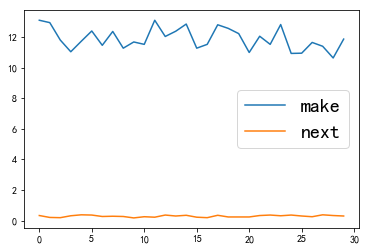

In [22]:
plt.plot(makeScores, label="make")
plt.plot(nextScores, label="next")
plt.legend(fontsize=20)
plt.show()

In [30]:
part

,epoch,pre,next,make,score,bleu
2496,40,你才不是黑木耳,你的陰道好看得不得了,她是不偷的 Max,False,0.232523
2497,40,噢 墨西哥餐廳,我把拉丁美洲的市場給忘了,不能再次考慮過激動,False,0.000000
2498,40,嗨 她有優惠券,都這會兒了 才說有優惠券啊,都這會兒了 才說有優惠券啊,True,1.000000
2499,40,上的湯都是涼的,瞧那耳環晃悠的 你以爲你是誰啊 吉普賽人,瞧那耳環晃悠的 你以為是這麼講的話,False,0.467283
2500,40,你看起來美極了,我是說 外套如此飄逸,是從哈佛從那個叫做好的人,False,0.160085
2501,40,伯特 我們參加的是好萊塢,情感終結游嗎,一個情感有的 是一個世界末日,False,0.058364
2502,40,用你的左手做 這樣就會覺得是別人做的,不是 如果你要做某件事 就好好做,不是 如果你要做某件事 就好好做,True,1.000000
2503,40,牦牛妹 快來,我需要你,真是太可愛 瞧瞧,False,0.000000
2504,40,放心吧 他不會再來騷擾你的,除非你哪兒開始癢癢了,除非你哪兒開始癢癢了,True,1.000000
2505,40,就不是傳統的波蘭婚禮,我覺得Oleg可以扮演畜生的角色,還有一個充滿男孩的,False,0.186905
